In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

In [ ]:
# Load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10
channel = 1
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#img_rows, img_cols = 32, 32
#num_classes = 10
#channel = 3

# Add the channel dimension to the images
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Normalize the pixel values to the range of [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [ ]:
# Our CNN model
def build_model(hp):
  model = Sequential()
  hp_layers = hp.Int('layers', 1, 3)
  hp_dropout = hp.Float('dropout', 0, 0.5, step=0.1)
  hp_lr = hp.Choice('learning_rate', values=[0.001, 0.005])
  
  for i in range(hp_layers):
    hp_filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32)
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp_filters, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp_dropout))

  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  # Compile model
  optimizer = keras.optimizers.Adam(learning_rate=hp_lr)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
RS_tuner = RandomSearch(build_model, max_trials=5, executions_per_trial=1, overwrite=True, objective="val_accuracy", directory="/tmp/tb")
RS_tuner.search_space_summary()

In [ ]:
RS_tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

In [ ]:
RS_tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.4
learning_rate: 0.001
filters_0: 96
filters_1: 32
Score: 0.9899166822433472
Trial summary
Hyperparameters:
layers: 1
dropout: 0.4
learning_rate: 0.001
filters_0: 32
filters_1: 64
Score: 0.984749972820282
Trial summary
Hyperparameters:
layers: 1
dropout: 0.30000000000000004
learning_rate: 0.001
filters_0: 128
Score: 0.984333336353302
Trial summary
Hyperparameters:
layers: 1
dropout: 0.0
learning_rate: 0.001
filters_0: 96
Score: 0.9833333492279053
Trial summary
Hyperparameters:
layers: 1
dropout: 0.2
learning_rate: 0.005
filters_0: 128
Score: 0.981249988079071


In [ ]:
best_hp = RS_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.4, 'learning_rate': 0.001, 'filters_0': 96, 'filters_1': 32}


In [ ]:
# Build the model with the best hyperparameters
model_RS = RS_tuner.hypermodel.build(best_hp)
history = model_RS.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
1875/1875 [==============================] - 30s 15ms/step - loss: 0.1910 - accuracy: 0.9404 - val_loss: 0.0548 - val_accuracy: 0.9811
Epoch 2/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0665 - accuracy: 0.9796 - val_loss: 0.0349 - val_accuracy: 0.9885
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0338 - val_accuracy: 0.9899
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0464 - accuracy: 0.9852 - val_loss: 0.0212 - val_accuracy: 0.9928
Epoch 5/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.0244 - val_accuracy: 0.9928


In [ ]:
# Evaluate the model
score = model_RS.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0], 'Test accuracy:', score[1])

Test loss: 0.024365590885281563 Test accuracy: 0.9927999973297119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


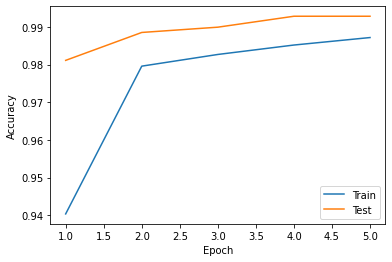

In [ ]:
# Plot accuracy
epochs = range(1,6)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='bottom right')
plt.show()

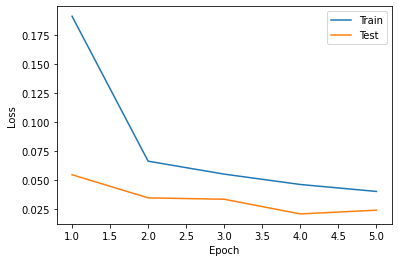

In [ ]:
# Plot loss
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
HB_tuner = Hyperband(build_model, hyperband_iterations=5, overwrite=True, objective="val_accuracy", directory="/tmp/tb")
HB_tuner.search_space_summary()

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005], 'ordered': True}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}


In [ ]:
HB_tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

Trial 11 Complete [00h 01m 23s]
val_accuracy: 0.98458331823349

Best val_accuracy So Far: 0.9869999885559082
Total elapsed time: 00h 13m 29s

Search: Running Trial #12

Hyperparameter    |Value             |Best Value So Far 
layers            |3                 |2                 
dropout           |0.1               |0.2               
learning_rate     |0.001             |0.005             
filters_0         |64                |96                
filters_1         |64                |64                
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 

Epoch 1/2


ValueError: ignored

In [ ]:
HB_tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.005
filters_0: 96
filters_1: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9869999885559082
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.005
filters_0: 96
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
filters_1: 32
Score: 0.9867500066757202
Trial summary
Hyperparameters:
layers: 2
dropout: 0.2
learning_rate: 0.001
filters_0: 64
filters_1: 32
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9863333106040955
Trial summary
Hyperparameters:
layers: 2
dropout: 0.30000000000000004
learning_rate: 0.005
filters_0: 64
filters_1: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.9860833287239075
Trial summary
Hyperparameters:
layers: 2
dropout: 0.1
learni

In [ ]:
best_hp = HB_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.2, 'learning_rate': 0.005, 'filters_0': 96, 'filters_1': 64, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [ ]:
# Build the model with the best hyperparameters
model_HB = HB_tuner.hypermodel.build(best_hp)
history = model_HB.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
1875/1875 [==============================] - 45s 23ms/step - loss: 0.1331 - accuracy: 0.9642 - val_loss: 0.0459 - val_accuracy: 0.9862
Epoch 2/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0511 - accuracy: 0.9847 - val_loss: 0.0421 - val_accuracy: 0.9862
Epoch 3/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.0400 - val_accuracy: 0.9872
Epoch 4/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.0422 - val_accuracy: 0.9877
Epoch 5/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0298 - val_accuracy: 0.9905


In [ ]:
# Evaluate the model
score = model_HB.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0], 'Test accuracy:', score[1])

Test loss: 0.029760533943772316 Test accuracy: 0.9904999732971191


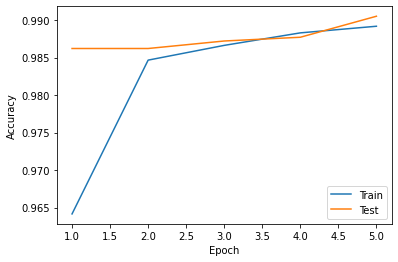

In [ ]:
# Plot accuracy
epochs = range(1,6)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

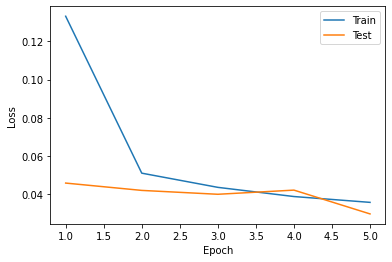

In [ ]:
# Plot loss
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
GP_tuner = BayesianOptimization(build_model, max_trials=5, overwrite=True, objective="val_accuracy", directory="/tmp/tb")
GP_tuner.search_space_summary()

Search space summary
Default search space size: 4
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.005], 'ordered': True}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}


In [ ]:
GP_tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

Trial 3 Complete [00h 01m 14s]
val_accuracy: 0.9829166531562805

Best val_accuracy So Far: 0.9887499809265137
Total elapsed time: 00h 08m 06s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
layers            |3                 |2                 
dropout           |0.5               |0.5               
learning_rate     |0.001             |0.001             
filters_0         |128               |64                
filters_1         |96                |128               

Epoch 1/5


ValueError: ignored

In [ ]:
GP_tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layers: 2
dropout: 0.5
learning_rate: 0.001
filters_0: 64
filters_1: 128
Score: 0.9887499809265137
Trial summary
Hyperparameters:
layers: 2
dropout: 0.0
learning_rate: 0.005
filters_0: 128
filters_1: 32
Score: 0.9882500171661377
Trial summary
Hyperparameters:
layers: 1
dropout: 0.5
learning_rate: 0.005
filters_0: 32
filters_1: 128
Score: 0.9829166531562805


In [ ]:
best_hp = GP_tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

{'layers': 2, 'dropout': 0.5, 'learning_rate': 0.001, 'filters_0': 64, 'filters_1': 128}


In [ ]:
# Build the model with the best hyperparameters
model_GP = GP_tuner.hypermodel.build(best_hp)
history = model_GP.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1991 - accuracy: 0.9477 - val_loss: 0.0628 - val_accuracy: 0.9828
Epoch 2/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0929 - accuracy: 0.9766 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 3/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0804 - accuracy: 0.9808 - val_loss: 0.0443 - val_accuracy: 0.9887
Epoch 4/5
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0642 - accuracy: 0.9833 - val_loss: 0.0344 - val_accuracy: 0.9906
Epoch 5/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0551 - accuracy: 0.9854 - val_loss: 0.0290 - val_accuracy: 0.9919


In [ ]:
# Evaluate the model
score = model_GP.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0], 'Test accuracy:', score[1])

Test loss: 0.029038576409220695 Test accuracy: 0.9919000267982483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


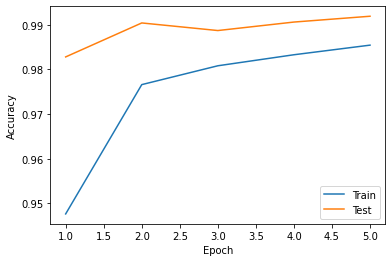

In [ ]:
# Plot accuracy
epochs = range(1,6)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='bottom right')
plt.show()

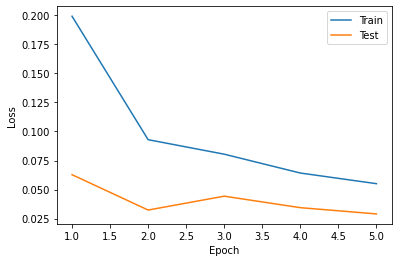

In [ ]:
# Plot loss
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()